# Mercari Price Suggestion Challenge

**Overview:** <br>
In this Kernel i try to adapt Natural langugae processing (NLP) Techniques in regression machine leaning alogrithem.<br>

**Data:**<br>
The data is obtain from kaggle competition "Mercari Price Suggestion Challenge" https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview

Dataset Features:<br>
**ID**: the id of the listing<br>
**Name**: the title of the listing<br>
**Item Condition**: the condition of the items provided by the seller<br>
**Category Name**: category of the listing<br>
**Brand Name**: brand of the listing<br>
**Shipping**: whether or not shipping cost was provided<br>
**Item Description**: the full description of the item<br>
**Price**: the price that the item was sold for. This is the target variable that you will predict. The unit is USD.<br>

**Challenge:**<br>
Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided text descriptions of their products, including details like product category name, brand name, and item condition.


In [1]:
# importing necessary library
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
import re
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet,ElasticNetCV
from pandas import DataFrame




In [2]:
# Importing data frame
train = pd.read_csv('C://Users//my//Desktop//train.tsv', sep = '\t',engine="python")
# Eleminate Entries with zero prices 
train=train[train.price!=0]
# Take a subset of data (to make it run faster )
reduced_X_train = train.sample(frac=0.1).reset_index(drop=True)
# Tale log transformaion of price 
reduced_y_train = np.log1p(reduced_X_train['price'])


# Data Overview

In [3]:
reduced_X_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,248961,Mac Fix plus coconut limited edition,1,Beauty/Makeup/Face,Mac Cosmetic,17.0,0,Price FIRM No free ship This is 30ml travel si...
1,281952,Baseball Hat,3,Men/Men's Accessories/Hats,Thrasher,8.0,1,Thrifted this item. Adjustable strap in the ba...
2,577278,Ovo Drake Size L Ovoxo Black Hoodie New,1,Men/Sweats & Hoodies/Hoodie,Gildan,24.0,0,"New, without tags, unworn. Please check out my..."
3,1099202,Clinique set,2,Beauty/Skin Care/Face,Clinique,9.0,0,No description yet
4,480394,Pink converse,2,Women/Shoes/Fashion Sneakers,Converse,32.0,0,"Worn once, original box. Good deal!"


In [4]:
print("the data dimension is"+str(reduced_X_train.shape))
print(reduced_X_train.dtypes)

the data dimension is(148166, 8)
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


In [5]:
reduced_X_train.astype('object').describe().transpose()

,count,unique,top,freq
train_id,148166,148166,289338,1
name,148166,137601,Bundle,252
item_condition_id,148166,5,1,64644
category_name,147502,1031,"Women/Athletic Apparel/Pants, Tights, Leggings",5820
brand_name,84916,2357,PINK,5404
price,148166,461,10,9825
shipping,148166,2,0,81915
item_description,148166,133762,No description yet,8246


# Data Cleaning

In [6]:
# Count missing values in out datsets
reduced_X_train.isna().sum()/len(reduced_X_train)

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004481
brand_name           0.426886
price                0.000000
shipping             0.000000
item_description     0.000000
dtype: float64

In [7]:
# Dealing with missing values( fill with appropiate values)
reduced_X_train['category_name'] = reduced_X_train['category_name'].fillna('Other').astype(str)
reduced_X_train['brand_name'] = reduced_X_train['brand_name'].fillna('missing').astype(str)
reduced_X_train['shipping'] = reduced_X_train['shipping'].astype(str)
reduced_X_train['item_condition_id'] = reduced_X_train['item_condition_id'].astype(str)
reduced_X_train['item_description'] = reduced_X_train['item_description'].fillna('None')


## Statistical Summary of Price

In [8]:
reduced_X_train.price.describe()

count    148166.000000
mean         26.743399
std          38.728236
min           3.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2009.000000
Name: price, dtype: float64

The summary indicate:<br>
**Skewed distribution** since the averge price is 26.72 and median is 17 <br>
75% of our data is below 29 <br>
**Oultiers** (max value is 2000) <br>

**Solution: log transformation**

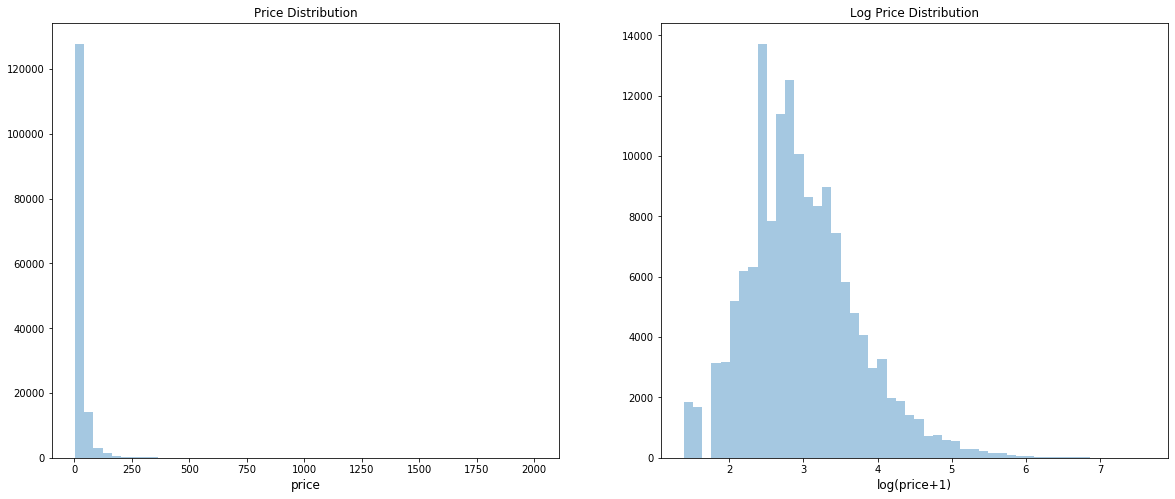

In [9]:
# Graph the price before and after transformation
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.distplot(reduced_X_train.price,kde=False)
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)


plt.subplot(1, 2, 2)
sns.distplot(reduced_y_train,kde=False)
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)


plt.show()

The above charts shows the effect of transformarion on price distribution

## Item condition distribution with price

In [10]:
print("There is about "+str(reduced_X_train.item_condition_id.nunique())+ "item condition in the dataset")

There is about 5item condition in the dataset


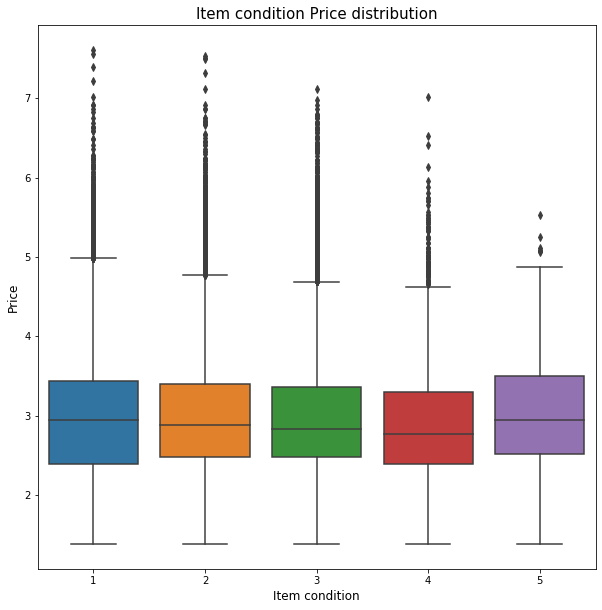

In [11]:
plt.figure(figsize=(10,10))
sns.boxplot(x=reduced_X_train.item_condition_id,y=reduced_y_train)
plt.xlabel("Item condition",fontsize=12)
plt.ylabel("Price",fontsize=12)
plt.title("Item condition Price distribution",fontsize=15)
plt.show()

## Shipping versus price

In [12]:
reduced_X_train.shipping.value_counts()/len(reduced_X_train)

0    0.55286
1    0.44714
Name: shipping, dtype: float64

In [13]:
print("The average price if the shipping is paid by seller is "+ str(reduced_X_train.price[reduced_X_train.shipping==1].mean()))
print("The average price if the shipping is paid by buyer is "+ str(reduced_X_train.price[reduced_X_train.shipping==0].mean()))


The average price if the shipping is paid by seller is nan
The average price if the shipping is paid by buyer is nan


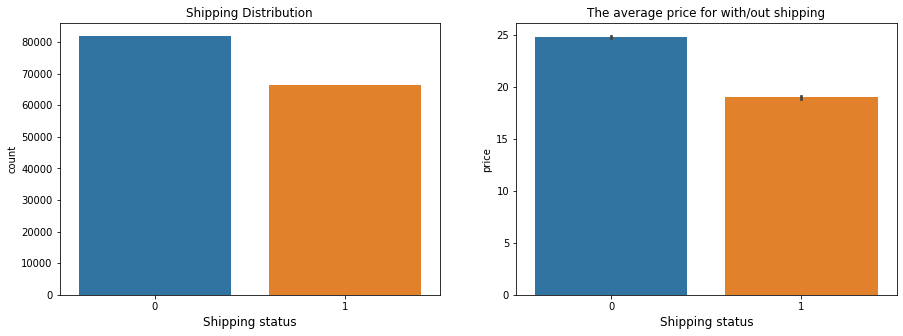

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.countplot(x="shipping",data=reduced_X_train)
plt.xlabel('Shipping status', fontsize=12)
plt.title('Shipping Distribution', fontsize=12)


plt.subplot(1, 2, 2)
sns.barplot(x="shipping",y="price",data=reduced_X_train[reduced_X_train.price<=100])
plt.xlabel('Shipping status', fontsize=12)
plt.title('The average price for with/out shipping', fontsize=12)


plt.show()

## Item category analysis

In [15]:
print("There is "+ str(reduced_X_train.category_name.nunique())+" category in this datasets")

There is 1032 category in this datasets


In [16]:
#splitting category name
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

reduced_X_train['category_main'], reduced_X_train['category_sub1'], reduced_X_train['category_sub2'] = zip(*reduced_X_train['category_name'].apply(transform_category_name))

cat_train = reduced_X_train[['category_main','category_sub1','category_sub2']]

cat_train.head()

,category_main,category_sub1,category_sub2
0,Beauty,Makeup,Face
1,Men,Men's Accessories,Hats
2,Men,Sweats & Hoodies,Hoodie
3,Beauty,Skin Care,Face
4,Women,Shoes,Fashion Sneakers


In [17]:
print('Number of Main category is '+ str(cat_train.category_main.nunique()))
print('Number of subcategory 1 is '+ str(cat_train.category_sub1.nunique()))
print('Number of subcategory 2 is '+ str(cat_train.category_sub2.nunique()))

Number of Main category is 10
Number of subcategory 1 is 113
Number of subcategory 2 is 720


### Top Category

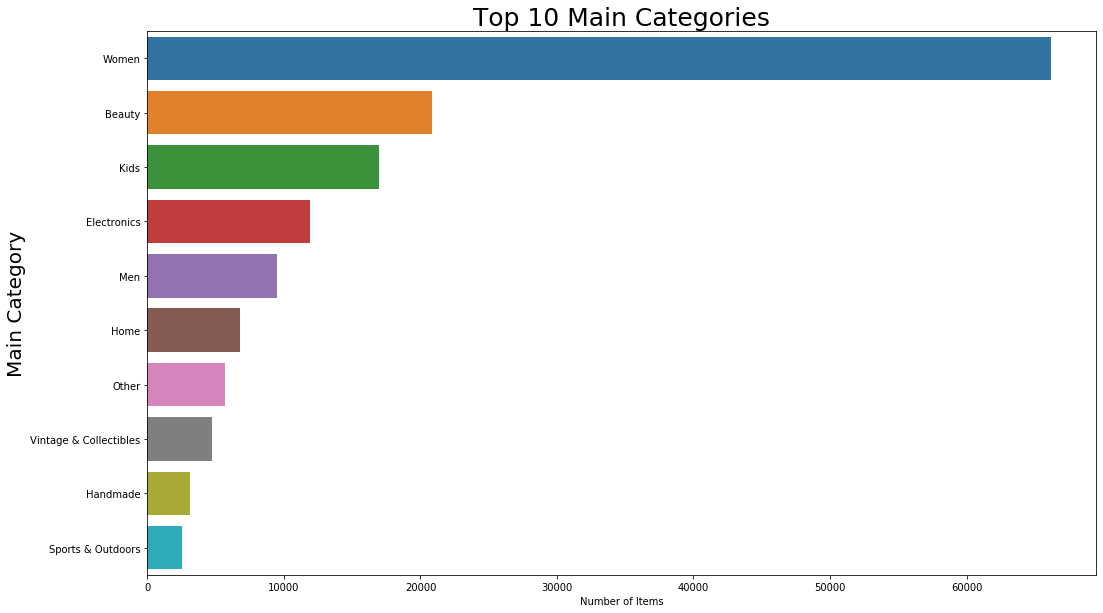

In [18]:
plt.figure(figsize=(17,10))
sns.countplot(y="category_main",data=cat_train, order=cat_train["category_main"].value_counts().index)
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

In [19]:
cat_train["category_main"].value_counts()/len(cat_train)

Women                     0.446668
Beauty                    0.140734
Kids                      0.114237
Electronics               0.080565
Men                       0.063922
Home                      0.045820
Other                     0.038099
Vintage & Collectibles    0.031789
Handmade                  0.021044
Sports & Outdoors         0.017123
Name: category_main, dtype: float64

There is interesting insight here that more that 50% of products are coming from categories **women and beauty**

## Brand analysis

In [20]:
print(" Number of Brands in this datasets is "+str(reduced_X_train.brand_name.nunique()))

 Number of Brands in this datasets is 2358


### Top 20 frequent brand

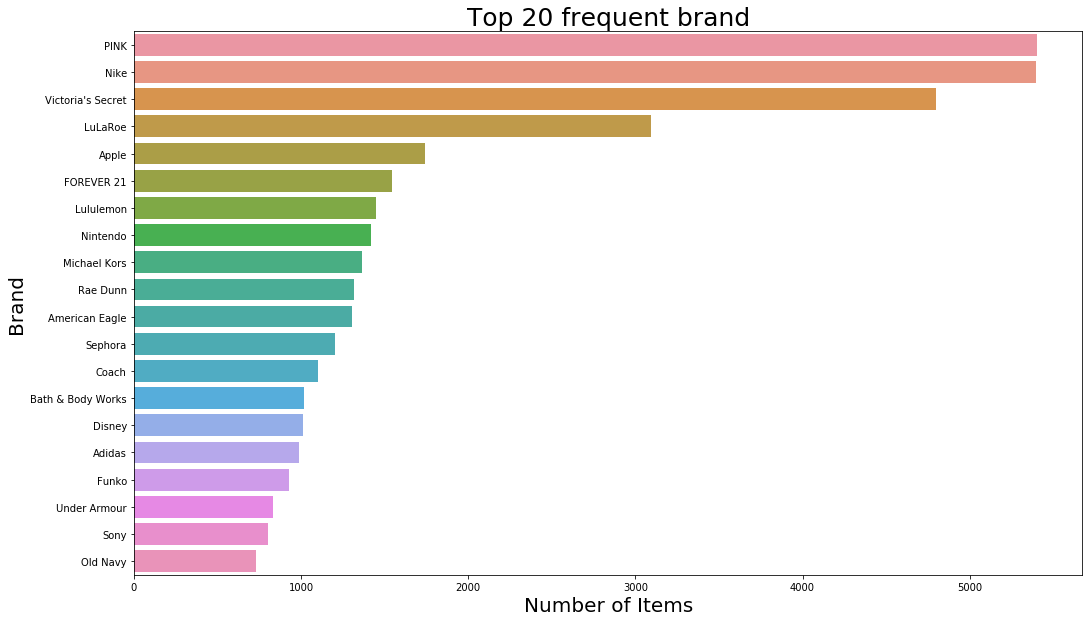

In [21]:
plt.figure(figsize=(17,10))
sns.countplot(y="brand_name",data=reduced_X_train, order=reduced_X_train["brand_name"].value_counts()[1:21].index)
plt.title('Top 20 frequent brand', fontsize = 25)
plt.ylabel('Brand', fontsize = 20)
plt.xlabel('Number of Items',fontsize = 20)
plt.show()

### Top 20 expensive brands

In [22]:
brand_price= reduced_X_train.groupby("brand_name")["price"].mean().to_frame()
brand_price=brand_price.sort_values(by="price",ascending=False).reset_index()
brand_price.head()

,brand_name,price
0,Goyard,1350.000000
1,Demdaco,848.000000
2,Alexander McQueen,614.500000
3,The Instrument Store,463.000000
4,Celine,425.444444


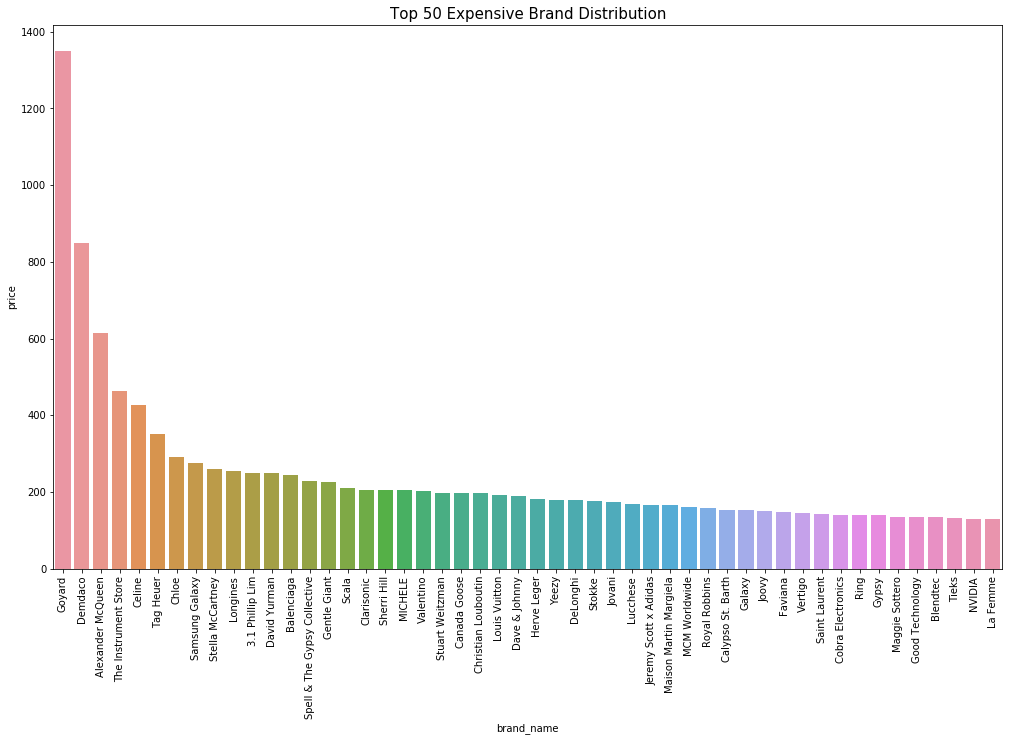

In [23]:
plt.figure(figsize=(17,10))
ax=sns.barplot(x="brand_name",y="price",data=brand_price[:50])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 50 Expensive Brand Distribution', fontsize=15)
plt.show()

# Text cleaning

### Feature Extraction

In [24]:
reduced_X_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_main,category_sub1,category_sub2
0,248961,Mac Fix plus coconut limited edition,1,Beauty/Makeup/Face,Mac Cosmetic,17.0,0,Price FIRM No free ship This is 30ml travel si...,Beauty,Makeup,Face
1,281952,Baseball Hat,3,Men/Men's Accessories/Hats,Thrasher,8.0,1,Thrifted this item. Adjustable strap in the ba...,Men,Men's Accessories,Hats
2,577278,Ovo Drake Size L Ovoxo Black Hoodie New,1,Men/Sweats & Hoodies/Hoodie,Gildan,24.0,0,"New, without tags, unworn. Please check out my...",Men,Sweats & Hoodies,Hoodie
3,1099202,Clinique set,2,Beauty/Skin Care/Face,Clinique,9.0,0,No description yet,Beauty,Skin Care,Face
4,480394,Pink converse,2,Women/Shoes/Fashion Sneakers,Converse,32.0,0,"Worn once, original box. Good deal!",Women,Shoes,Fashion Sneakers


In [25]:
reduced_X_train=reduced_X_train.drop(["price","category_main","category_sub1","category_sub2"],axis=1)

### Bag of word

In [26]:
#Copyright 2018, Data Science Dream Job LLC
from sklearn.pipeline import FeatureUnion

default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(reduced_X_train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=55000,
        stop_words='english',
        preprocessor=build_preprocessor('item_description'))),
])

In [27]:
# This is another way to transform our words into features but it takes too long to run the model
#cv = CountVectorizer(stop_words='english',ngram_range=(1, 2))

#X_name = cv.fit_transform(reduced_X_train['name'])
#X_category=cv.fit_transform(reduced_X_train['category_name'])

#X_dummies = csr_matrix(pd.get_dummies(reduced_X_train[['item_condition_id', 'shipping','brand_name']], sparse=True).values)

#tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
#X_description = tv.fit_transform(reduced_X_train['item_description'])
#reduced_Xt_train = hstack((X_dummies, X_description,X_category,X_name)).tocsr()


In [28]:
# Create Transformed Train Set
reduced_Xt_train = vectorizer.fit_transform(reduced_X_train.values)
reduced_Xt_train

<148166x108397 sparse matrix of type '<class 'numpy.float64'>'
	with 4628222 stored elements in Compressed Sparse Row format>

In [29]:
def get_rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))


# Modeling

### Model evaluation

Since we have large number of features so i regulization regression technique is adapted over multiple regression to control multicollinearity and automatic feature selection

In [35]:
#This is one way to evaluate out models togother but it takes too long to run
#models = []
#models.append(('Ridge', Ridge(solver = "lsqr", fit_intercept=False, random_state=42)))
#models.append(('Lasso', Lasso(fit_intercept=True, random_state=42)))
#models.append(('lasticNet', ElasticNet(alpha=0.1,random_state=42)))

#rmse_training=[]
#rmse_validation=[]
#names=[]

# Create 3-Fold CV
#cv = KFold(n_splits=3, shuffle=True, random_state=42)
#for train_ids, valid_ids in cv.split(reduced_Xt_train):
    #for name, model in models:

        # fitting the model
        #model.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
        # Predict & Evaluate Training Score
        #y_pred_train = model.predict(reduced_Xt_train[train_ids])
        #rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
        #rmse_training.append(rmsle_train)
    
        # Predict & Evaluate Validation Score
        #y_pred_valid = model.predict(reduced_Xt_train[valid_ids])
        #rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
        #rmse_validation.append(rmsle_valid)
        #names.append(name)


In [31]:
%%time
# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_LASSO = Lasso(fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_LASSO.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_LASSO.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_LASSO.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LASSO Training RMSLE: {rmsle_train:.5f}')
    print(f'LASSO Validation RMSLE: {rmsle_valid:.5f}')

LASSO Training RMSLE: 0.74705
LASSO Validation RMSLE: 0.74078
LASSO Training RMSLE: 0.74501
LASSO Validation RMSLE: 0.74488
LASSO Training RMSLE: 0.74283
LASSO Validation RMSLE: 0.74922


In [33]:
%%time

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=False, random_state=42)
    
    # Fit LGBM Model
    model_ridge.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')

LGBM Training RMSLE: 0.31153
LGBM Validation RMSLE: 0.50535
LGBM Training RMSLE: 0.30968
LGBM Validation RMSLE: 0.50748
LGBM Training RMSLE: 0.30838
LGBM Validation RMSLE: 0.50714
Wall time: 7.95 s


In [34]:
%% time
# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(reduced_Xt_train):
    # Define LGBM Model
    model_elastic = ElasticNet(alpha=0.1,random_state=42)
    
    # Fit LGBM Model
    model_elastic.fit(reduced_Xt_train[train_ids], reduced_y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_elastic.predict(reduced_Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, reduced_y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_elastic.predict(reduced_Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, reduced_y_train[valid_ids])
    
    print(f'ElasticNet Training RMSLE: {rmsle_train:.5f}')
    print(f'ElasticNet Validation RMSLE: {rmsle_valid:.5f}')

ElasticNet Training RMSLE: 0.72887
ElasticNet Validation RMSLE: 0.72309
ElasticNet Training RMSLE: 0.72703
ElasticNet Validation RMSLE: 0.72711
ElasticNet Training RMSLE: 0.72580
ElasticNet Validation RMSLE: 0.73155


From the above results you can notice that ridge regression has lower error.

In [36]:
# Train and Test Split
train_X, test_X, train_y, test_y = train_test_split(reduced_Xt_train, reduced_y_train, test_size=0.2, random_state=144)
# Define Ridge Model
model_ridge = Ridge(solver = "lsqr", fit_intercept=False, random_state=42)
    
# Fit Ridge Model
model_ridge.fit(train_X, train_y)
    
# Evaluate Training Score
ridge_y_pred = model_ridge.predict(test_X)

In [37]:
y_test=pd.DataFrame(np.expm1(test_y))
y_test["predicted"]=np.expm1(ridge_y_pred)



Text(0.5, 1.0, 'Actual versus predicted')

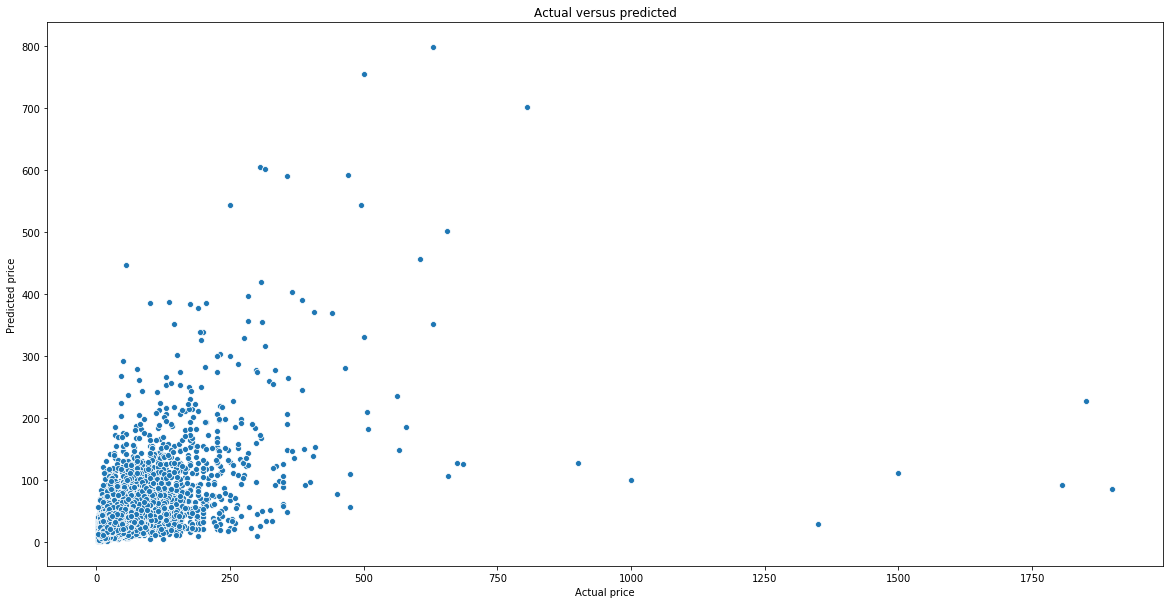

In [40]:
plt.figure(figsize=(20,10))
sns.scatterplot(x="price", y="predicted", data=y_test)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual versus predicted")




# Notes
1-The model is fitted on subset of original data, lower error will be if it's fitted on the entire dataset. <br>
2-The model performed worse on higher values of price because of less observation.<br>
3-You can fit ensemble techniques to get less error but model interpertation will be complicated
